In [1]:
from numba import jit
import numpy as np

@jit
def create_polygon_jit(points, n, target_n, gridsize, curr_area, min_area, soln):
    if n >= 3:
        x1, y1 = points[n-3][0]-points[n-2][0], points[n-3][1]-points[n-2][1]
        x2, y2 = points[n-1][0]-points[n-2][0], points[n-1][1]-points[n-2][1]
        if x1*y2-x2*y1<=0: #Angle > 180
            return False
        if x1*x2+y1*y2>0: #Angle >= 90
            return False
        if points[1][0]==0 and points[n-1][0]==0:
            return True
        add_area = points[n-1][0]*points[n-2][1]-points[n-1][1]*points[n-2][0]
        if add_area <= 0:
            return True
        curr_area += add_area
        if curr_area >= min_area[0]:
            return True
        if n == target_n:
            min_area[0] = curr_area
            soln[:] = points.copy()
            return True
        
        min_i = max(0, points[n-1][0] - 3)
        max_i = min(gridsize, points[n-1][0] + 4)

        min_j = max(-gridsize//2, points[n-1][1] - 3)
        max_j = min(gridsize//2, points[n-1][1] + 4)
        
        if x2>0:
            if y2>0:
                if x2>y2:
                    for j in range(min_j, max_j):
                        for i in range(max_i-1,min_i-1,-1):
                            points[n] = (i,j)
                            if not create_polygon_jit(points, n+1, target_n, gridsize, curr_area, min_area, soln):
                                break
                        if points[n][0] == max_i-1:
                            break
                else:
                    for j in range(max_j-1, min_j-1, -1):
                        for i in range(max_i-1,min_i-1,-1):
                            points[n] = (i,j)
                            if not create_polygon_jit(points, n+1, target_n, gridsize, curr_area, min_area, soln):
                                break
                        if points[n][0] == max_i-1:
                            break
            else:
                if x2>-y2:
                    for i in range(max_i-1,min_i-1,-1):
                        for j in range(min_j, max_j):
                            points[n] = (i,j)
                            if not create_polygon_jit(points, n+1, target_n, gridsize, curr_area, min_area, soln):
                                break
                        if points[n][1] == min_j:
                            break
                else:
                    for i in range(min_i, max_i):
                        for j in range(min_j, max_j):
                            points[n] = (i,j)
                            if not create_polygon_jit(points, n+1, target_n, gridsize, curr_area, min_area, soln):
                                break
                        if points[n][1] == min_j:
                            break
        else:
            if y2>0:
                if -x2>y2:
                    for i in range(min_i, max_i):
                        for j in range(max_j-1, min_j-1, -1):
                            points[n] = (i,j)
                            if not create_polygon_jit(points, n+1, target_n, gridsize, curr_area, min_area, soln):
                                break
                        if points[n][1] == max_j-1:
                            break
                else:
                    for i in range(max_i-1,min_i-1,-1):
                        for j in range(max_j-1, min_j-1, -1):
                            points[n] = (i,j)
                            if not create_polygon_jit(points, n+1, target_n, gridsize, curr_area, min_area, soln):
                                break
                        if points[n][1] == max_j-1:
                            break
            else:
                if -x2>-y2:
                    for j in range(max_j-1, min_j-1, -1):
                        for i in range(min_i, max_i):
                            points[n] = (i,j)
                            if not create_polygon_jit(points, n+1, target_n, gridsize, curr_area, min_area, soln):
                                break
                        if points[n][0] == min_i:
                            break
                else:
                    for j in range(min_j, max_j):
                        for i in range(min_i, max_i):
                            points[n] = (i,j)
                            if not create_polygon_jit(points, n+1, target_n, gridsize, curr_area, min_area, soln):
                                break
                        if points[n][0] == min_i:
                            break
    
    else:
        min_i = max(0, points[n-1][0] - 3)
        max_i = min(gridsize, points[n-1][0] + 4)

        min_j = max(-gridsize//2, points[n-1][1] - 3)
        max_j = min(gridsize//2, points[n-1][1] + 4)
        
        for i in range(min_i, max_i):
            for j in range(min_j, max_j):
                points[n] = (i,j)
                result = create_polygon_jit(points, n+1, target_n, gridsize, curr_area, min_area, soln)
    points[n] = (0,0)
    return True

In [2]:
import time
def crossproduct(p1, mid, p2):
    xm, ym = mid[0], mid[1]
    return ((p1[0] - xm)*(p2[1] - ym)-(p1[1] - ym)*(p2[0] - xm))
def double_area(points):
    return abs(sum(crossproduct(points[0], points[i-1], points[i]) for i in range(2, len(points))))
n = 19
points = np.array([(0,0)]*n) #List([(0,0)]*n)
gridsize = 15
results = []
soln = points.copy()
start = time.perf_counter()
_ = create_polygon_jit(points, 1, n, gridsize, 0, np.array([gridsize**2]), soln)
shape = soln.tolist()
print(round(time.perf_counter()-start, 2), "seconds,", double_area(soln), "area, points:", shape)

438.59 seconds, 213 area, points: [[0, 0], [0, 1], [1, 3], [2, 4], [4, 5], [5, 5], [8, 4], [10, 3], [11, 2], [12, 0], [13, -3], [13, -4], [12, -6], [11, -7], [10, -7], [7, -6], [5, -5], [2, -3], [1, -2]]


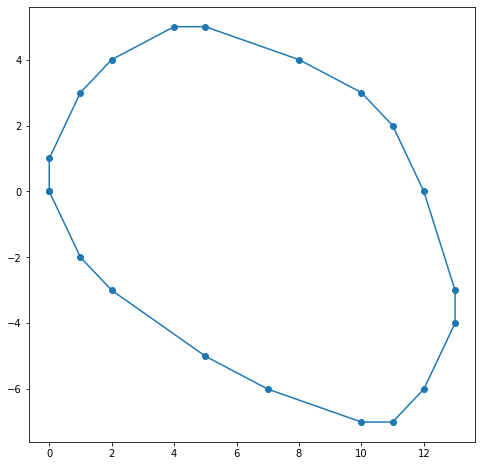

In [3]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [8, 8]
i,j = zip(*shape)
i = list(i) + [i[0]]
j = list(j) + [j[0]]
plt.plot(i,j)
plt.scatter(i,j)
plt.show()